In [1]:
import sys
print(sys.version)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, regularizers
from keras.layers import Flatten, add, Dense, Dropout 
from keras.callbacks import ModelCheckpoint, EarlyStopping


print("TensorFlow version:", tf.__version__)
tf.keras.backend.set_floatx('float64')

TensorFlow version: 2.9.2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import csv
import random

import cv2
import imutils
import glob
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
#Określenie ścieżek do plików
test_zip = '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Test.zip'
test_csv = 'test.csv'

train_zip = '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Train_2.zip'
train_csv = 'train_2.csv'

valid_csv = 'valid_2.csv'

folder = '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/'
slesh = '/'
png = '.png'

In [6]:
#!unzip '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Train_2.zip' -d '/content/train/'
#!unzip '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Test.zip' -d '/content/test/'
#!unzip '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Valid_2.zip' -d '/content/valid/'

In [7]:
def release_list(a):
    
    del a[:]
    del a

In [8]:
#Wczytanie etykiet do treninegu 

with open(folder+train_csv,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value_train = []
for i in new[0]:
    value_train.append(int(i))    
    
print(len(value_train))

20160


In [9]:
#Wczytanie etykiet do walidacji

with open(folder+valid_csv,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value_valid = []
for i in new[0]:
    value_valid.append(int(i))    
    
print(len(value_valid))

2520


In [10]:
#Wczytanie etykiet do testowania

with open(folder+test_csv,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value_test = []
for i in new[0]:
    value_test.append(int(i))    
    
print(len(value_test))

2520


In [11]:
#Wczytanie zdjęć treningowych (80% całego zbioru)
images_train = []
size = len(value_train)

for i in range(size):
    im = Image.open('/content/train/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images_train.append(arr_im) 
print(len(images_train))

20160


In [12]:
#Wczytanie zdjęć treningowych (10% całego zbioru)
images_valid = []
size = len(value_valid)

for i in range(size):
    im = Image.open('/content/valid/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images_valid.append(arr_im) 
print(len(images_valid))

2520


In [13]:
#Wczytanie zdjęć testowych (10% całego zbioru)
images_test = []
size = len(value_test)

for i in range(size):
    im = Image.open('/content/test/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images_test.append(arr_im) 
print(len(images_test))

2520


In [14]:
x_train = np.array(images_train)
x_test = np.array(images_test)
x_valid = np.array(images_valid)

y_train = np.array(value_train)
y_test = np.array(value_test)
y_valid = np.array(value_valid)

0


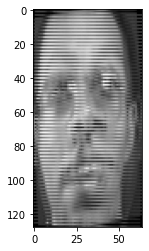

In [15]:
a = 19000
plt.imshow(x_train[a],cmap = 'gray')
print(y_train[a])

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)))
model.add(layers.Dense(1, activation='relu'))


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 62, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 14, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 30, 14, 32)       128       
 ormalization)                                                   
                                                        

In [18]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy','mse'])

#Funcka umożliwia zatrzymanie się uczenia 
#gdy wartość strat przstanie maleć
EarlyStop = EarlyStopping(monitor='val_loss',  
                          verbose=1, 
                          patience=10)


ModelCheck = ModelCheckpoint(filepath='/content/drive/MyDrive/Sieci/Przeplatane_forefox.h5',
                             monitor='val_loss',
                             save_best_only=True)

history = model.fit(x=x_train, 
                    y=y_train, 
                    epochs=100,
                    batch_size=128,
                    #validation_split=0.1,
                    validation_data = (x_valid, y_valid),
                    callbacks = [EarlyStop, ModelCheck]
                   )

Epoch 1/100
158/158 [==============================] - 36s 202ms/step - loss: 2.2142 - accuracy: 0.9132 - mse: 0.0860 - val_loss: 0.2780 - val_accuracy: 0.5008 - val_mse: 0.2453
Epoch 2/100
158/158 [==============================] - 31s 196ms/step - loss: 0.0245 - accuracy: 0.9941 - mse: 0.0106 - val_loss: 0.1707 - val_accuracy: 0.9274 - val_mse: 0.1626
Epoch 3/100
158/158 [==============================] - 31s 195ms/step - loss: 0.0151 - accuracy: 0.9968 - mse: 0.0076 - val_loss: 0.1414 - val_accuracy: 0.7706 - val_mse: 0.1358
Epoch 4/100
158/158 [==============================] - 31s 195ms/step - loss: 0.0102 - accuracy: 0.9985 - mse: 0.0051 - val_loss: 0.0700 - val_accuracy: 0.9242 - val_mse: 0.0651
Epoch 5/100
158/158 [==============================] - 30s 191ms/step - loss: 0.0089 - accuracy: 0.9988 - mse: 0.0043 - val_loss: 0.1018 - val_accuracy: 0.8385 - val_mse: 0.0976
Epoch 6/100
158/158 [==============================] - 30s 191ms/step - loss: 0.0080 - accuracy: 0.9991 - mse:

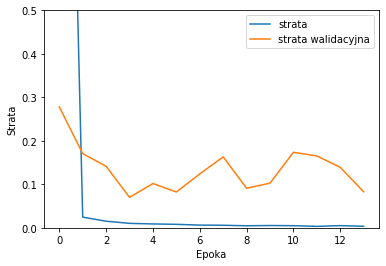

In [19]:
plt.plot(history.history['loss'], label='strata')
plt.plot(history.history['val_loss'], label = 'strata walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.ylim([0.0, 0.5])
plt.legend(loc='upper right')

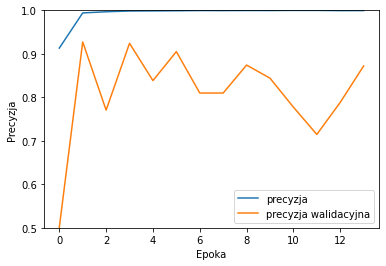

In [20]:
plt.plot(history.history['accuracy'], label='precyzja')
plt.plot(history.history['val_accuracy'], label = 'precyzja walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Precyzja')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [21]:
model.evaluate(x_test,  y_test, verbose=2)

79/79 - 1s - loss: 0.0408 - accuracy: 0.9417 - mse: 0.0392 - 1s/epoch - 17ms/step


[0.040781629798235755, 0.9416666666666667, 0.03918897599561723]

In [22]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Sieci/Przeplatane_forefox.h5')

In [23]:
best_model.evaluate(x_test,  y_test, verbose=2)

79/79 - 1s - loss: 0.0513 - accuracy: 0.9615 - mse: 0.0465 - 1s/epoch - 15ms/step


[0.05132697237701492, 0.9615079365079365, 0.04645424766649294]

In [24]:
predict_x = best_model.predict(x_test) 

predictions = (predict_x > 0.5).astype("int32")

79/79 [==============================] - 1s 12ms/step


In [25]:
names = [['Tn','Nn'],['Np', 'Tp']]
names = np.reshape(names,(2,2))
print(names)

conf = tf.math.confusion_matrix(y_test,predictions)

print(conf)

[['Tn' 'Nn']
 ['Np' 'Tp']]
tf.Tensor(
[[1230   30]
 [  67 1193]], shape=(2, 2), dtype=int32)
